Ejercicio 1

In [32]:
# ignore pesky warnings
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [33]:
file_list = glob.glob(os.getcwd() + '/data/dump/*.csv')
append_csv = []
for f in file_list:
    append_csv.append(pd.read_csv(f, index_col=None,
header=0).drop(columns='Unnamed: 0'))
df_lyrics = pd.concat(append_csv)
df_lyrics.columns = ['artist', 'genre', 'song', 'lyrics']



In [47]:
df_lyrics['genre'].value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: genre, dtype: int64

In [34]:
df_lyrics.head()

,artist,genre,song,lyrics
0,Public Enemy,hiphop,You're Gonna Get Yours,"(Flavor Flav) \n Oh-oh Chuck, they out to get ..."
1,Public Enemy,hiphop,Sophisticated Bitch,"That woman in the corner, cold playin' the rol..."
2,Public Enemy,hiphop,Miuzi Weighs A Ton,"Yo Chuck, run a power move on them \n (Yeah) \..."
3,Public Enemy,hiphop,Timebomb,"(Intro - Flavor Flav) \n Hey, Chuck, we got so..."
4,Public Enemy,hiphop,Too Much Posse,(Intro - Flavor Flav) \n What do you got to sa...


In [35]:
#Ejercicio 2: Matriz de ocurrencias

counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
transformed_feats = counter.fit_transform(df_lyrics['lyrics'].values)

transformed_feats.shape

nombres= counter.get_feature_names_out()
freq_word=transformed_feats.toarray().sum(axis=0)

df_count=pd.DataFrame([list(nombres),list(freq_word)]).T
df_count.columns=['nombre','freq']
df_count=df_count.sort_values(by='freq', ascending=False)
df_count.head()

,nombre,freq
2918,niggas,3057
2985,ooh,2719
83,ah,2476
2383,la,2202
3568,rock,2165


In [36]:
#Ejercicio 3: Entrenamiento modelo LDA

search_params = {'n_components': [5, 10, 15], 'learning_decay': [0.7, 0.5]}
# Por defecto GridSearchCV implementa 3 validaciones. Hay un total de 18 m
# odelos por estimar.
cv_lda_model = GridSearchCV(LatentDirichletAllocation(learning_method='online'),param_grid=search_params,n_jobs=-1).fit(transformed_feats)

In [37]:
best_lda = cv_lda_model.best_estimator_
print("Best hyperparams: {}".format(cv_lda_model.best_params_))
print("Best Loglikelihood: {}".format(cv_lda_model.best_score_))
print("Best Preplexity: {}".format(best_lda.perplexity(transformed_feats)))

Best hyperparams: {'learning_decay': 0.7, 'n_components': 5}
Best Loglikelihood: -1320041.4854099138
Best Preplexity: 2227.230972527836


In [38]:
#Ejercicio 4: Inferencia e identificacion de topicos

# mediante .components_ podemos extraer una matriz que entrega lasdistribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_lda.components_):
    # para cada tópico
    print("tópico: {}".format(topic_id + 1))
# mediante argsort logramos ordenar los elementos por magnitud
# para los elementos más relevantes ordenados por argsort, buscamos su correlativo
# en la matriz dispersa y devolvemos el nombre.
# finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names_out()[i] for i in
topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
ah rock everybody roll dance ha uh beat mos yes ma def hands comin party
tópico: 2
sun hell pain sky war kill cold dark fear rain coming burn earth fight lord
tópico: 3
ooh la going whoa mama getting girls round crazy fucking alright okay babe looking christmas
tópico: 4
niggas niggaz fuckin rap uh ba wit gon na bitches son word verse kid bout
tópico: 5
believe wrong true thought yes forever didn dream care tonight friends maybe help today moment


In [39]:
#Ejercicio 5: Identificacion de probabilidades


#generamos una transformación de los datos a distribución de tópico por palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
 
# esta transformación la podemos coaccionar a un dataframe de la siguiente manera
 
topics_for_each_doc = pd.DataFrame(
# pasamos esta matriz y la redondeamos en 3 decimales
np.round(fit_best_lda, 3),
# agregamos un índice
index=df_lyrics.index)

topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x),
range(1, best_lda.n_components + 1)))

concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values,
axis=1) + 1



In [40]:
concatenated_df

,artist,genre,song,lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Public Enemy,hiphop,You're Gonna Get Yours,"(Flavor Flav) \n Oh-oh Chuck, they out to get ...",0.183,0.124,0.437,0.255,0.001,3
1,Public Enemy,hiphop,Sophisticated Bitch,"That woman in the corner, cold playin' the rol...",0.074,0.002,0.002,0.476,0.446,4
2,Public Enemy,hiphop,Miuzi Weighs A Ton,"Yo Chuck, run a power move on them \n (Yeah) \...",0.430,0.090,0.001,0.438,0.041,4
3,Public Enemy,hiphop,Timebomb,"(Intro - Flavor Flav) \n Hey, Chuck, we got so...",0.588,0.001,0.001,0.318,0.091,1
4,Public Enemy,hiphop,Too Much Posse,(Intro - Flavor Flav) \n What do you got to sa...,0.129,0.136,0.003,0.488,0.244,4
...,...,...,...,...,...,...,...,...,...,...
125,Mos Def,hiphop,Travellin' Man,Yeah yo yo what time the plane leavin'? \n Ah ...,0.801,0.195,0.001,0.001,0.001,1
126,Mos Def,hiphop,Universal Magnetic,"(Mos Def) \n Yeah, ha ha ha \n A-B-boys rock t...",0.800,0.001,0.001,0.189,0.009,1
127,Mos Def,hiphop,Very Well,So what you doing \n I'm feeling very well \n ...,0.273,0.001,0.093,0.474,0.159,4
128,Mos Def,hiphop,What's Beef?,(Talib Kweli) \n Yo I was sold to a sick Europ...,0.102,0.082,0.001,0.814,0.001,4


<AxesSubplot: >

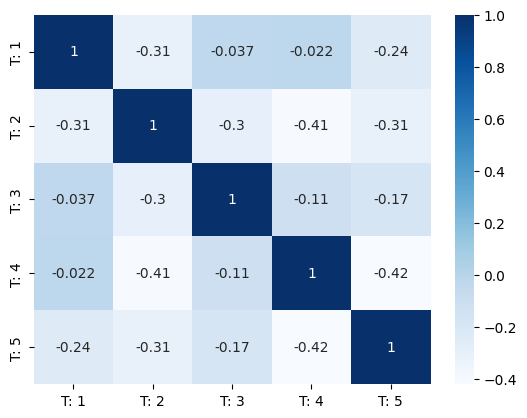

In [41]:
sns.heatmap(concatenated_df.loc[:,'T: 1':'T: 5'].corr(), annot=True, cmap='Blues')

El topico 5 con el topico 3 y 4 son los que tienen mayor correlacion negativa.
El topico 1 con el topico 2 tienen muy poca correlacion
El topico 2 es el que menos correlacion tiene con los demas topicos.